# Overlapping analysis with constant attribution score cutoff (top 100) for AMR genes

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read tokens from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf


,contig_id,start_position,end_position,tokens,score,tube_id
0,1,1,3,GAA,0.024555,AH21B049
1,1,4,12,AAACCCCGG,0.019281,AH21B049
2,1,13,17,TCAAT,0.042749,AH21B049
3,1,18,22,AAGGC,0.058446,AH21B049
4,1,23,27,CGGGG,-0.002272,AH21B049
...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077
247349729,5,259939,259942,GGCC,0.024973,ALF22C077


## Calculate token length

In [3]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,1,3,GAA,0.024555,AH21B049,3
1,1,4,12,AAACCCCGG,0.019281,AH21B049,9
2,1,13,17,TCAAT,0.042749,AH21B049,5
3,1,18,22,AAGGC,0.058446,AH21B049,5
4,1,23,27,CGGGG,-0.002272,AH21B049,5
...,...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077,8
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077,8
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077,10
247349729,5,259939,259942,GGCC,0.024973,ALF22C077,4


In [4]:
highscoreDf = bedDf.sort_values(by=['score'], ascending=False)[:1000]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
106971408,5,275000,275001,CG,0.994362,AH18L059,2
197943648,4,402509,402513,TCGAT,0.991059,ALF22L083,5
197109127,1,1197500,1197506,CGTTGGC,0.984545,ALF22H044,7
117870964,1,622506,622509,GCAG,0.971440,AH19H076,4
220974321,4,240022,240024,TCA,0.962870,ALF22D139,3
...,...,...,...,...,...,...,...
233658566,3,375156,375161,TTCCCA,0.357662,AH19D073,6
155252028,3,400764,400769,GGTTTT,0.357557,ALF22L072,6
33317553,2,378264,378269,GGTTTT,0.357557,AH21F008,6
130613306,1,592562,592571,AAATGCATTT,0.357203,AH21B054,10


In [5]:
highscoreDf.shape

(1000, 7)

In [6]:
highscoreDf.token_length.value_counts()

token_length
6     286
7     203
5     135
4     117
3      78
8      71
9      54
10     24
2      10
11      9
1       8
16      5
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

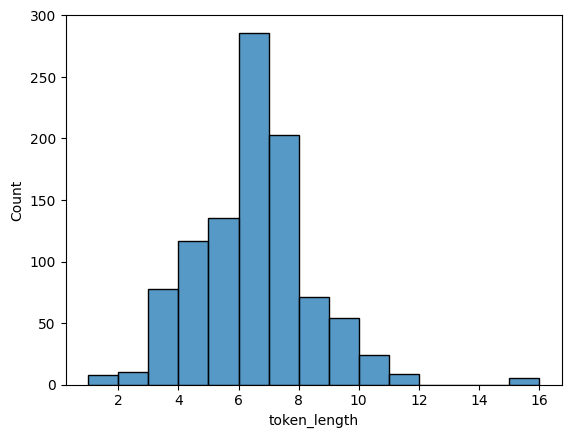

In [7]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read amrfinder annotations

In [8]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

overlappingGenesDict = {}
overlappingAnnotationsDict = {}

for tokenLengthCutoff in range(5, 11):
    print('tokenLengthCutoff: ', str(tokenLengthCutoff))
    tokensDf = highscoreDf[highscoreDf.token_length == tokenLengthCutoff]
    overlappingDfList = []
    for tubeId in tokensDf.tube_id.unique():
        tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
        amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
        if(amrfinderFile.exists()):
            amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
            mergedDf = tubeidHighscoreDf.merge(
                amrfinderDf,
                how='inner',
                left_on = ['contig_id'],
                right_on = ['Contig id'],
            )
            mergedDf['tube_code'] = tubeId
            tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
            overlappingDfList.append(mergedDf)

    overlappingDf = pd.concat(overlappingDfList, ignore_index=True)

    overlappingGenesDict['Token Length = ' + str(tokenLengthCutoff)] = overlappingDf['Gene symbol'].unique()
    overlappingAnnotationsDict['Token Length = ' + str(tokenLengthCutoff)] = overlappingDf

tokenLengthCutoff:  5
tokenLengthCutoff:  6
tokenLengthCutoff:  7
tokenLengthCutoff:  8
tokenLengthCutoff:  9
tokenLengthCutoff:  10


## Generate upset plot

/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

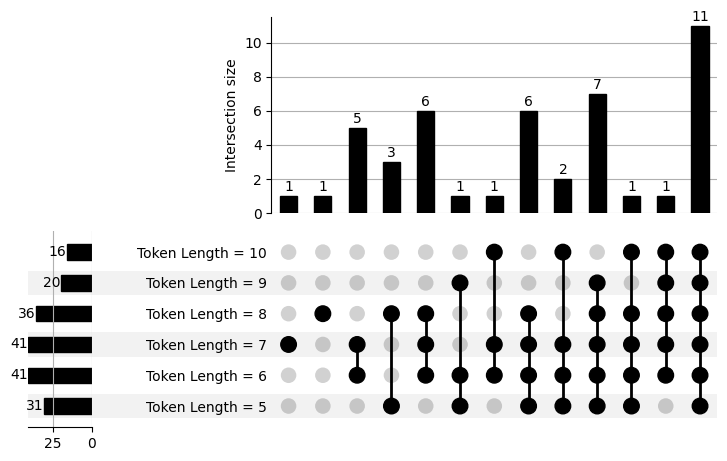

In [9]:
from upsetplot import UpSet

from upsetplot import from_contents


ax_dict = UpSet(from_contents(overlappingGenesDict), show_counts=True, sort_categories_by='input').plot()

## Obtain singature genes

In [10]:
singatureGenes = set()
singatureGenes.update(set.intersection(*[set([v for v in value if str(v) != 'nan']) for key, value in overlappingGenesDict.items()]))
singatureGenes

{'acrF',
 'asr',
 'blaEC',
 'emrE',
 'fdeC',
 'iss',
 'mdtM',
 'sslE',
 'ybtP',
 'ybtQ',
 'ymgB'}

In [11]:
allAnnotationsDf = pd.concat([value for key, value in overlappingAnnotationsDict.items()], ignore_index=True)
allAnnotationsDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,4,402509,402513,TCGAT,0.991059,ALF22L083,5,NaN,4,288417,288746,-,emrE,multidrug efflux SMR transporter EmrE,plus,STRESS,BIOCIDE,EFFLUX,EFFLUX,BLASTX,110,110,100.0,98.18,110,CAA77936.1,multidrug efflux SMR transporter EmrE,NaN,NaN,ALF22L083
1,4,402509,402513,TCGAT,0.991059,ALF22L083,5,NaN,4,346859,348658,-,ybtQ,yersiniabactin ABC transporter ATP-binding/permease protein YbtQ,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,600,600,100.0,99.67,600,AAC69584.1,yersiniabactin ABC transporter ATP-binding/permease protein YbtQ,NaN,NaN,ALF22L083
2,4,402509,402513,TCGAT,0.991059,ALF22L083,5,NaN,4,348648,350447,-,ybtP,yersiniabactin ABC transporter ATP-binding/permease protein YbtP,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,600,600,100.0,99.67,600,CAA21388.1,yersiniabactin ABC transporter ATP-binding/permease protein YbtP,NaN,NaN,ALF22L083
3,5,380015,380020,CGCATC,0.789321,ALF22L083,6,NaN,5,186939,188069,-,blaEC,BlaEC family class C beta-lactamase,plus,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,377,377,100.0,99.73,377,AAZ85965.1,cephalosporin-hydrolyzing class C beta-lactamase EC-5,NaN,NaN,ALF22L083
4,5,380015,380020,CGCATC,0.789321,ALF22L083,6,NaN,5,325030,326034,-,papG-III,P fimbria tip G-adhesin PapG-III,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,335,335,100.0,97.91,335,CAA43558.1,P fimbria tip G-adhesin PapG-III,NaN,NaN,ALF22L083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,1,592600,592610,TATAATGCGCC,0.427181,AH21B054,11,NaN,1,390900,392318,-,espX1,type III secretion system effector EspX1,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,473,473,100.0,93.02,473,ADD54679.1,type III secretion system effector EspX1,NaN,NaN,AH21B054
1750,3,92783,92789,AGCCGGA,0.375737,AH21B054,7,NaN,3,110688,111017,+,emrE,multidrug efflux SMR transporter EmrE,plus,STRESS,BIOCIDE,EFFLUX,EFFLUX,BLASTX,110,110,100.0,98.18,110,CAA77936.1,multidrug efflux SMR transporter EmrE,NaN,NaN,AH21B054
1751,1,592562,592571,AAATGCATTT,0.357203,AH21B054,10,NaN,1,109553,110683,-,blaEC,BlaEC family class C beta-lactamase,plus,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,377,377,100.0,98.14,377,WP_063610930.1,class C extended-spectrum beta-lactamase EC-15,NaN,NaN,AH21B054
1752,1,592562,592571,AAATGCATTT,0.357203,AH21B054,10,NaN,1,288362,289591,-,mdtM,multidrug efflux MFS transporter MdtM,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,410,410,100.0,98.05,410,AAC77293.1,multidrug efflux MFS transporter MdtM,NaN,NaN,AH21B054


In [12]:
allAnnotationsDf[allAnnotationsDf['Gene symbol'].isin(singatureGenes)][['Gene symbol', 'Sequence name', 'Element type']].drop_duplicates()

,Gene symbol,Sequence name,Element type
0,emrE,multidrug efflux SMR transporter EmrE,STRESS
1,ybtQ,yersiniabactin ABC transporter ATP-binding/permease protein YbtQ,VIRULENCE
2,ybtP,yersiniabactin ABC transporter ATP-binding/permease protein YbtP,VIRULENCE
3,blaEC,BlaEC family class C beta-lactamase,AMR
16,asr,acid resistance repetitive basic protein Asr,STRESS
49,fdeC,intimin-like adhesin FdeC,VIRULENCE
52,acrF,multidrug efflux RND transporter permease subunit AcrF,AMR
53,iss,increased serum survival lipoprotein Iss,VIRULENCE
54,sslE,lipoprotein metalloprotease SslE,VIRULENCE
58,ymgB,biofilm/acid-resistance regulator AriR,STRESS
